# ERA5 Land Sea Mask

- data: [Copernicus CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)
- download the Copernicus land-sea-mask for one timestep (using ERA5_download_land_sea_mask.py (or Download tool on CDS))
- just double check that nothing changes between 1982 and 2024 (1 January 00:00)
- the land-sea-mask ranges from 0 to 0.5 → create a binary mask
    - proportion of land/water (ocean or inland)
    - lsm > 0.5 → mix of land and inland water but not ocean
    - lsm < 0.5 → can only be water (lake cover could then be used to determine ocean to inland water surface)
- save the binary mask as ERA5_land_sea_mask.nc

In [1]:
import xarray as xr
import os
import cdsapi

## Download

In [49]:
# download the data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')

c = cdsapi.Client()
for YEAR in ['1982','2024']:
    c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': 'land_sea_mask',
            'year': '2024',
            'month': '01',
            'day': '01',
            'time': '00:00',
            'area': [
                45, -20, 35,
                -5,
            ],
            'format': 'netcdf',
        },
        f'../Data.nosync/ERA5_land_sea_mask_{YEAR[2:4]}.nc')

2024-07-01 15:48:34,710 INFO Welcome to the CDS
2024-07-01 15:48:34,712 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-07-01 15:48:34,919 INFO Request is completed
2024-07-01 15:48:34,921 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data6/adaptor.mars.internal-1719830450.8369377-6988-9-4060a729-f89f-4f42-8aff-9294ed990b7e.nc to ../Data.nosync/ERA5_land_sea_mask_82.nc (6.4K)
2024-07-01 15:48:35,423 INFO Download rate 12.7K/s                              
2024-07-01 15:48:35,521 INFO Welcome to the CDS
2024-07-01 15:48:35,522 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2024-07-01 15:48:35,757 INFO Downloading https://download-0013-clone.copernicus-climate.eu/cache-compute-0013/cache/data6/adaptor.mars.internal-1719830450.8369377-6988-9-4060a729-f89f-4f42-8aff-9294ed990b7e.nc to ../Data.nosync/ERA5_land_sea_mask_24.nc (6

## Load and compare

In [25]:
# import ERA5 land-sea mask
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
lsm_82 = xr.open_dataset('ERA5_land_sea_mask_82.nc')
lsm_24 = xr.open_dataset('ERA5_land_sea_mask_24.nc')

In [26]:
# It only has data for one timestep so I removed the time variable
lsm_82 = lsm_82.squeeze('time').drop_vars('time')
lsm_24 = lsm_24.squeeze('time').drop_vars('time')

In [27]:
# compare the datasets (just to duble check that the vars stay the same over the years)
test = lsm_82 == lsm_24

In [28]:
test

<xarray.Dataset> Size: 3kB
Dimensions:    (longitude: 61, latitude: 41)
Coordinates:
  * longitude  (longitude) float32 244B -20.0 -19.75 -19.5 ... -5.5 -5.25 -5.0
  * latitude   (latitude) float32 164B 45.0 44.75 44.5 44.25 ... 35.5 35.25 35.0
Data variables:
    lsm        (latitude, longitude) bool 3kB True True True ... True True True

In [29]:
# check if the the number of variables in the land sea mask is the same as the 
# sum of the 'True' values where lsm_82 and lsm_24 agree 
# if it matches the number of variables are the same
if len(test.lsm.values.flatten()) == test.lsm.sum():
    print('The land-sea mask is the same in 1982 as 2024 and does not change')
else:
    print('The lands-seam mask changes')

The land-sea mask is the same in 1982 as 2024 and does not change


## Make mask binary

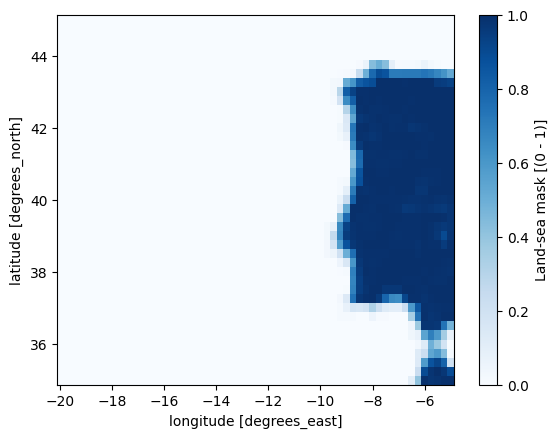

In [30]:
# the values in the mask range between 0-1
    # proportion of land/water (ocean or inland)
    # lsm > 0.5 → mix of land and inland water but not ocean
    # lsm < 0.5 → can only be water (lake cover could then be used to determine ocean to inland water surface)
lsm_24.lsm.plot(cmap = 'Blues')

## Mask
- find the balance between pixels that seem to contain 'land data' (large values in MTSS) and 'ocean data'
- I tried selcting only pixels with 100% water (value 0) -› remove all values near the coast
- settled on 0.2 

In [39]:
# make a binary 
t_lsm_24 = lsm_24
var = 0.25 # choose 0.25 as it removes enough of the 'land data' without removing all near shore data

t_lsm_24 = t_lsm_24.where(t_lsm_24.lsm > var, 0) # land
t_lsm_24 = t_lsm_24.where(t_lsm_24.lsm < var, 1) # water

# I want to swap the values around -> ocean = 1 (True), land = 0 (False)
t_lsm_24['lsm'] = 1 - t_lsm_24.lsm

In [40]:
# check if exact var occurs
(t_lsm_24.lsm == var).sum()

<xarray.DataArray 'lsm' ()> Size: 8B
array(0)

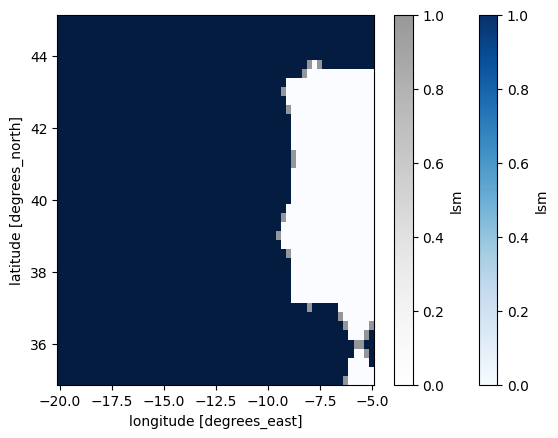

In [41]:
t_lsm_24.lsm.plot(cmap = 'Blues')

# control
c_lsm_24 = lsm_24
c_lsm_24 = c_lsm_24.where(c_lsm_24.lsm > 0.5, 0) # land
c_lsm_24 = c_lsm_24.where(c_lsm_24.lsm < 0.5, 1) # water
c_lsm_24['lsm'] = 1 - c_lsm_24.lsm
c_lsm_24.lsm.plot(cmap = 'Greys', alpha = 0.4)
# gray pixels are pixels that change between land and ocean if I adapt the threshold

## Set attributes

In [42]:
# set attrs and update the name of the coordinates to match the ERA5 mean trubulent surface 
# stress dataset
lsm_24 = t_lsm_24
lsm_24.lsm.attrs.update({"long_name" : "Land-sea mask", "standard_name" : "land_binary_mask", 
                         "units" : "1 (True) : ocean \n0 (False): land"})
lsm_24 = lsm_24.rename({'longitude' : 'lon', 'latitude' : 'lat'})
# change the mask variable to a boolean datatype
lsm_24 = lsm_24.astype(bool)

In [43]:
lsm_24

<xarray.Dataset> Size: 3kB
Dimensions:  (lat: 41, lon: 61)
Coordinates:
  * lon      (lon) float32 244B -20.0 -19.75 -19.5 -19.25 ... -5.5 -5.25 -5.0
  * lat      (lat) float32 164B 45.0 44.75 44.5 44.25 ... 35.75 35.5 35.25 35.0
Data variables:
    lsm      (lat, lon) bool 3kB True True True True ... False False False False
Attributes:
    Conventions:  CF-1.6
    history:      2024-07-01 10:40:51 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

## Save

In [44]:
## save as ERA5_land_sea_mask.nc
lsm_24.to_netcdf('Land_sea_mask.nc')